# I. Web crawling Quest
- 최근 일주일간의 일일박스오피스 50위까지의 데이터를 selenium과 bs4를 활용해서 가져오는 코드를 작성
- 가져온데이터를날짜별로dataframe을만든후,시각화

### <방법>
1. 수집하려는 웹 페이지의 소스를 분석하여, 필요한 데이터가 담긴 반복되는 패턴 블록을 찾아낸다.
2. 반복되는 패턴 블록의 계층 구조를 찾아내 각각의 요소를 정리한다.
3. 계층 구조 내에서 필요한 요소를 따로 찾아 정리한다.

In [ ]:
import pandas as pd
import numpy as np

In [2]:
import requests # urllib 말고 requests 써주세요 (urllib은 구식입니다!)
from bs4 import BeautifulSoup as bs
import lxml
from selenium import webdriver # 자바스크립트로 전송 되는 데이터는 url - html에 안붙어있습니다.. 페이지를 열어줘야 데이터가 와요!
import time
import requests
from selenium.webdriver.common.keys import Keys

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = '/Users/alegro/Downloads/chromedriver' # 크롬드라이브 경로 지정  ## 맥과 리눅스는 exe.를 붙이지 않습니다.x
driver = webdriver.Chrome(path)
driver.implicitly_wait(3) #혹은 time.sleep(3)

In [4]:
driver.get("http://www.kobis.or.kr/kobis/business/stat/boxs/findDailyBoxOfficeList.do")
driver.implicitly_wait(3)

In [5]:
daily_boxoffice_html = driver.page_source
#print(daily_boxoffice_html)
parsed_daily_boxoffice_html = bs(daily_boxoffice_html, 'lxml')
daily_boxoffice = parsed_daily_boxoffice_html.find("tbody", {"id":"tbody_0"})
#print(daily_boxoffice.prettify())

In [6]:
#print(daily_boxoffice.prettify())

# Process
- 1) 더보기 버튼 50위까지 누르기
- 2) 박스오피스 크롤링

## 1) 더보기 버튼
- class가 more open, more 이렇게 두개가 있어서 
- 클래스를 open하나로 지정해서 element를 찾고 클릭하면
- 모든 리스트를 볼 수 없음
- -> xpath & more이 들어간 클래스의 element 를 찾는 방식으로 한다

https://stackoverflow.com/questions/21713280/find-div-element-by-multiple-class-names

In [ ]:
#버튼 클릭
#id로 찾으면 btn + 숫자 <-- 규칙이 없어서 자꾸 에러발생 ㅠ
#에러처리가 안되서 fail....

- 더보기 버튼: 원래는 div class ="more"
- 그런데 얘를 한번 누르면, div class ='more open' 으로 바뀐다 !! 
- more -> more open -> more -> more open -> ... 이렇게 됨

- 그래서 위의 코드들이 모든 더보기 버튼을 누를 수 없었던 거임!
- 어떻게 처리하지...

In [9]:
from selenium.webdriver.common.keys import Keys
# 다음과 같이 해결

more_elems=driver.find_elements_by_xpath("//*[starts-with(@id,'btn')]")
# 버튼을 클릭해줄때마다 10개씩 더 나오는 구조
# 50위까지 보려면 당일 순위의 더보기 버튼 *4 클릭 * 7일
lim=0
while lim<4:          
    for m in more_elems:
        m.send_keys(Keys.ENTER) # 예를 들어 4월 10일 더보기 버튼 클릭 
        driver.implicitly_wait(4)
        # for loop이 끝나면 7일 모두 한번씩 클릭한 것
    lim+=1
    #while loop이 끝나면 각각 4번씩 클릭한 것

## 2) weekly boxoffice crawling & preprocessing

In [10]:
def make_DF(data):
    daily_movies = {'영화명' : [],
    '순위 변동' : [],
    '개봉일' : [],
    '매출액' : [],
    '매출액점유율' : [],
    '관객수' : [],
    '누적관객수' : [],
    '스크린수' : [],
    '상영횟수' : []}
    movie_list = data.find_all("tr")
    for movie in movie_list:
        title_rank = movie.find("td").find_next_sibling("td").text
        daily_movies['영화명'].append(title_rank[:-5].strip())
        daily_movies['순위 변동'].append(title_rank[-4:].strip())
        daily_movies['개봉일'].append(movie.find("td").find_next_sibling("td").find_next_sibling("td").text.strip())
        daily_movies['매출액'].append(movie.find("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").text.strip())
        daily_movies['매출액점유율'].append(movie.find("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").text.strip())
        daily_movies['관객수'].append(movie.find("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").text.strip())
        daily_movies['누적관객수'].append(movie.find("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").text.strip())
        daily_movies['스크린수'].append(movie.find("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").text.strip())
        daily_movies['상영횟수'].append(movie.find("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").find_next_sibling("td").text.strip())
    
    daily_movies=pd.DataFrame(daily_movies) 
    
    return daily_movies

In [11]:
# 주간 박스오피스 ~ 50위까지
daily_boxoffice_html = driver.page_source
parsed_daily_boxoffice_html = bs(daily_boxoffice_html, 'lxml')
daily_boxoffice= parsed_daily_boxoffice_html.find_all("tbody",
                                                      id=lambda value: value and value.startswith("tbody_"))


In [12]:
outputs=['fri','thu','wed','tue','mon','sun','sat']
# data preprocess 한 애들을 넣을 변수 리스트!
for num,data in enumerate(daily_boxoffice):
    if num<7: #8이상부터는 이상한 값들이 들어감
        globals()[outputs[num]]=make_DF(data)
        #print(data.text)
    else:
        break

In [13]:
fri.head()

,영화명,순위 변동,개봉일,매출액,매출액점유율,관객수,누적관객수,스크린수,상영횟수
0,1917,1상승,2020-02-19,"22,687,060",14.2%,"2,530","745,007",329,569
1,엽문4: 더 파이널,1하락,2020-04-01,"21,897,500",13.7%,"2,438","43,445",180,474
2,오픈 더 도어,동일,2020-04-08,"14,036,400",8.8%,"1,511","4,719",155,320
3,주디,동일,2020-03-25,"13,463,160",8.5%,"1,499","76,883",261,445
4,인비저블맨,동일,2020-02-26,"10,499,960",6.6%,"1,117","560,737",204,296


In [14]:
#날짜 가져오기 --> 각 데이터 프레임에 매칭
date=[]
for i in range(0,7):
    dates_xpath = '//*[@id="content"]/div[4]/div[%d]/h4'%(4*i+2)
    dates = driver.find_element_by_xpath(dates_xpath)
    date.append(dates.text)
date

['2020년 04월 10일(금)',
 '2020년 04월 09일(목)',
 '2020년 04월 08일(수)',
 '2020년 04월 07일(화)',
 '2020년 04월 06일(월)',
 '2020년 04월 05일(일)',
 '2020년 04월 04일(토)']

In [15]:
#outputs=['fri','thu','wed','tue','mon','sun','sat']
for i,df in enumerate(outputs):
    globals()[df]['날짜']=date[i]

In [16]:
fri.head(1)

,영화명,순위 변동,개봉일,매출액,매출액점유율,관객수,누적관객수,스크린수,상영횟수,날짜
0,1917,1상승,2020-02-19,"22,687,060",14.2%,"2,530","745,007",329,569,2020년 04월 10일(금)


In [19]:
#concat 전에 ranking을 유지해야함!!
for df in outputs:
    globals()[df]=globals()[df].reset_index().rename(columns={'index':'순위'})
    

In [29]:
fri.head(1)

,순위,영화명,순위 변동,개봉일,매출액,매출액점유율,관객수,누적관객수,스크린수,상영횟수,날짜
0,0,1917,1상승,2020-02-19,"22,687,060",14.2%,"2,530","745,007",329,569,2020년 04월 10일(금)


In [82]:
#마지막으로 7주일간의 데이터프레임을 concat
temp=pd.DataFrame()
for output in outputs:
    temp=pd.concat([temp,globals()[output]], axis=0)

In [83]:
temp['순위']=temp['순위']+1
temp.head(1)

,순위,영화명,순위 변동,개봉일,매출액,매출액점유율,관객수,누적관객수,스크린수,상영횟수,날짜
0,1,1917,1상승,2020-02-19,"22,687,060",14.2%,"2,530","745,007",329,569,2020년 04월 10일(금)


In [84]:
len(temp) #concat이 잘 된것을 확인

350

In [85]:
temp=temp.reset_index()

In [86]:
temp=temp.drop('index',axis=1)

### 순위변동 칼럼 조정

In [87]:
def ranking(row):
    if '상승' in row:
        return row[:1]
    elif '하락' in row:
        return int(row[:1])*-1
    elif '동일' in row:
        return 0 

In [88]:
temp['순위 변동']=temp['순위 변동'].apply(lambda row: ranking(row))

In [89]:
temp.columns

Index(['순위', '영화명', '순위 변동', '개봉일', '매출액', '매출액점유율', '관객수', '누적관객수', '스크린수',
       '상영횟수', '날짜'],
      dtype='object')

### 날짜 전처리- 요일만 따로 떼어내기

In [90]:
temp['날짜_']=temp['날짜'].apply(lambda row: row[:-3])

In [91]:
import re
temp['날짜_']=temp['날짜_'].apply(lambda row: re.sub('[^0-9]', '', row))

In [92]:
temp['날짜_']=temp['날짜_'].astype('datetime64')

In [93]:
temp['요일']=temp['날짜'].apply(lambda row: row[-2:-1])

In [94]:
temp=temp.drop('날짜', axis=1)

In [95]:
temp=temp[['날짜_','요일','순위','영화명', '순위 변동', '개봉일', '매출액', '매출액점유율', '관객수', '누적관객수', '스크린수',
       '상영횟수']]

In [96]:
temp=temp.sort_values(by='날짜_')

In [106]:
df=temp
df=df.reset_index().drop('index', axis=1)

In [107]:
df=df.sort_values(by=['날짜_','순위'])

In [108]:
df=df.rename(columns={'날짜_':'날짜'})

## 3) Data Visualization

In [172]:
import matplotlib.pyplot as plt 
import platform                

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': #맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':#윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

In [110]:
#연속형 변수들 str-> int로 바꿔주기
def to_num(col_name):
    df[col_name]=df[col_name].apply(lambda row: row.replace(',',''))
    df[col_name]=pd.to_numeric(df[col_name])
    return df[col_name]

In [114]:
col_name_list=['매출액', '관객수', '누적관객수', '스크린수', '상영횟수']
for i in col_name_list:
    to_num(i)

In [116]:
df.head()

,날짜,요일,순위,영화명,순위 변동,개봉일,매출액,매출액점유율,관객수,누적관객수,스크린수,상영횟수
22,2020-04-04,토,1,엽문4: 더 파이널,0,2020-04-01,75121500,20.0%,8288,23532,199,618
21,2020-04-04,토,2,1917,1,2020-02-19,51792600,13.8%,5681,729730,362,638
20,2020-04-04,토,3,주디,-1,2020-03-25,44614800,11.9%,5010,66420,352,718
19,2020-04-04,토,4,인비저블맨,1,2020-02-26,32247140,8.6%,3453,552161,280,497
18,2020-04-04,토,5,n번째 이별 중,1,2020-04-01,27768800,7.4%,2906,7783,171,396


### 주간 top 5 영화들의 순위 변동

In [164]:
data1=df.loc[df['순위']<6][['요일','영화명','순위','순위 변동']]

In [178]:
data1=data1.groupby(['요일','영화명','순위']).count().reset_index()
data1.head()

,요일,영화명,순위,순위 변동
0,금,1917,1,1
1,금,엽문4: 더 파이널,2,1
2,금,오픈 더 도어,3,1
3,금,인비저블맨,5,1
4,금,주디,4,1


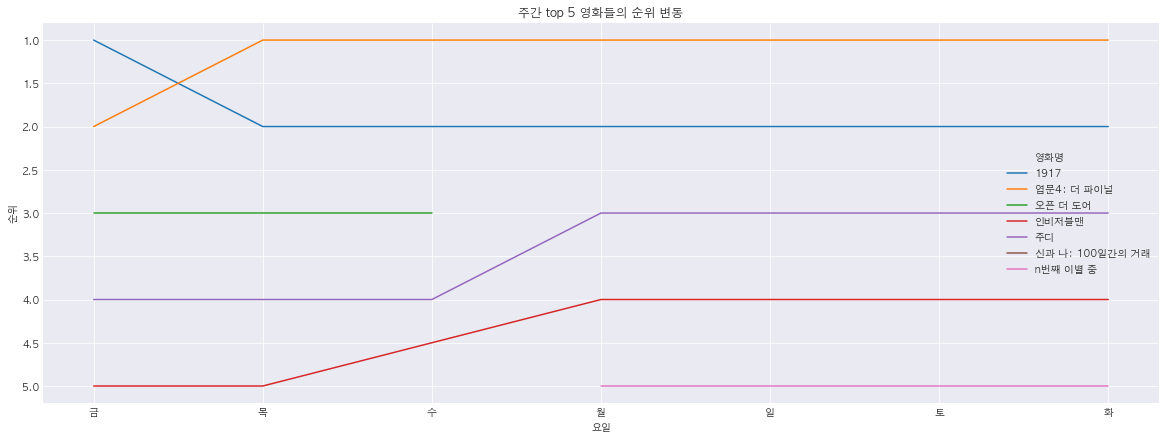

In [180]:
f, ax =plt.subplots(figsize=(20,7))
sns.lineplot(x='요일',y='순위',hue='영화명',data=data1)
plt.title('주간 top 5 영화들의 순위 변동')
plt.gca().invert_yaxis()
plt.show()

# II. Data Visualization Quest
- 1. Bike_id (바이크 하나하나에 붙어있는 고유 아이디) 에 따른 trip_duration을 시각화해주세요. 
    - 평균이어도 좋고, 누적이어도 좋습니다. 해석 보태 주세요.
    - Groupby 함수 사용해주시면 편합니다.
- 2. Bike_id, Trip_duration, + 한 가지 변수 더 추가해서 3개 이상 변수 시각화 방식으로 시각화 해주세요. 

#### 시각화에서 중요한 건 범주형변수, 연속형변수 두가지로 구분하고 시작하는 것 (한 번 더 복습!)
> 범주형 변수 : 빈도(frequency) 계산 가능 <br/>
> 연속형 변수 : 평균, 표준편차, 분산 등의 수학적 계산 가능


- dtypes로 전체 변수 타입을 확인할때, 범주형이어도 연속형 변수 dtype일 수 있다 <br/>
- 이 예시에서는 trip_duration, day_since_register 연속형 변수, 그 외는 다 범주형<br/>
- 실제로 연속형이 아닌데, int64(연속형)인 변수들을 string으로 만들어준다

In [628]:
df=pd.read_csv("nyc_citibike.csv",encoding='euc-kr') # 한글이 들어간 csv는 encoding 인자를 넣어주는 것이 좋음

### 1. Bike_id (바이크 하나하나에 붙어있는 고유 아이디) 에 따른 trip_duration을 시각화해주세요. 
    - 평균이어도 좋고, 누적이어도 좋습니다. 해석 보태 주세요.
    - Groupby 함수 사용해주시면 편합니다.

In [587]:
#초-> 분으로 스케일 변경
df['trip_duration']=df['trip_duration'].apply(lambda row: round(row/60,2))

In [588]:
df['bike_id'].nunique()
#10000개가 넘는 bike id를 모두 시각화하는 것은 시각적으로 유의미하지 않다고 판단

10147

In [589]:
#plot에 잘 나타내기 위해 bike id: int-> str
df['bike_id']=df['bike_id'].astype(str)

### 주행 시간 평균 top 30 

In [590]:
#주행시간의 평균이 상위권인 자전거만 추출 (30대)
cut_id=df.groupby('bike_id').sum()['trip_duration'].reset_index()
cut_id=cut_id.sort_values(by='trip_duration', ascending=False).iloc[:30]
cut_id=pd.merge(cut_id['bike_id'], df, on='bike_id', how='left')


In [591]:
#각 자전거의 운행 횟수를 카운트한다
#운행횟수가 많을 수록, 자전거가 놓여진 장소가 주요 자전거이용객들의 거주지(사용지)라고 생각
trip_cnt=cut_id.groupby('bike_id').count()['trip_duration'].reset_index().sort_values(by='trip_duration').rename(columns={'trip_duration':'trip_count'})


In [592]:
#주행횟수를 기준으로 오름차순 정렬 -> 주행거리 sum과 비교
data3=pd.merge(cut_id,trip_cnt
               , on='bike_id', how='left').sort_values(by='trip_count')#.reset_index()

In [593]:
data3=data3.groupby(['bike_id','trip_count']).mean()['trip_duration'].reset_index()

In [594]:
data3.head()#.sort_values(by='trip_count')

,bike_id,trip_count,trip_duration
0,14808,6,157.530000
1,14927,3,794.200000
2,15298,1,1731.400000
3,15310,4,512.107500
4,16577,6,160.863333


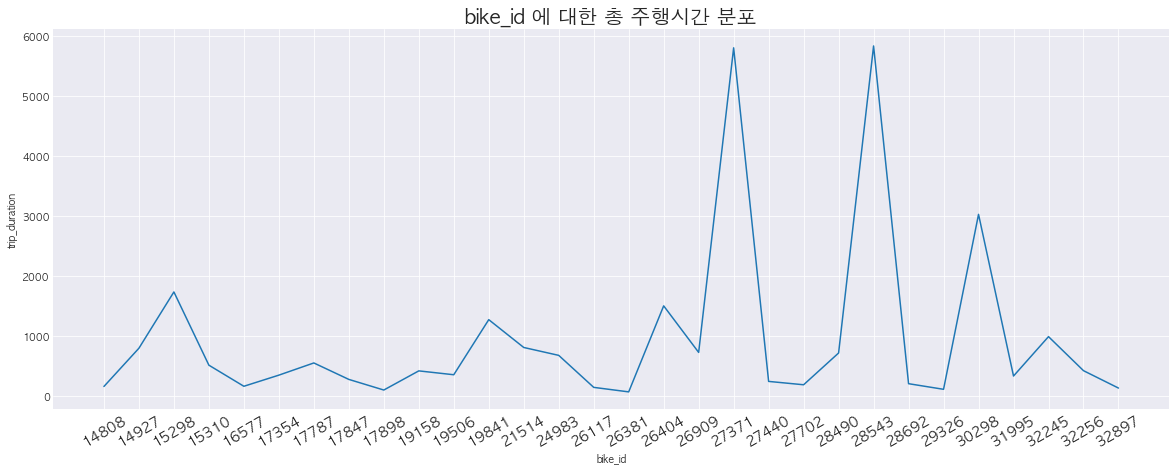

In [603]:
#bike_id는 trip_count(운행 횟수)에 따라 오름차순으로 정렬
#이에 대한, trip_duration의 분포를 살펴보았다
f, ax=plt.subplots(figsize=(20,7))
#sns.barplot(x='bike_id', y='trip_duration', data=data3,order = data3['bike_id'].sort_values())
sns.lineplot(x='bike_id', y='trip_duration', data=data3)
plt.xticks(rotation=30, fontsize=14)
ax.set(xlabel='bike_id')
plt.title('bike_id 에 대한 총 주행시간 분포', fontsize=20)
plt.show()


주행 횟수에 따른 주행시간의 관계가 크게 보이지 않는다

### 주행 횟수 top 30

In [596]:
#운행횟수가 상위권인 자전거만 추출 (30대)
cut_id2=df.groupby('bike_id').count()['start_date'].reset_index().rename(columns={'start_date':'trip_cnt'})
cut_id2=cut_id2.sort_values(by='trip_cnt', ascending=False).iloc[:30]
cut_id2=pd.merge(cut_id2, df, on='bike_id', how='left')

In [599]:
cut_id2.head()

,bike_id,trip_cnt,start_date,end_date,start_hour,end_hour,trip_duration,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,usertype,birth_year,gender,day_since_register
0,25697,34,2018-05-01,2018-05-01,6,6,10.90,3435,Grand St & Elizabeth St,40.718822,-73.995960,473,Rivington St & Chrystie St,40.721101,-73.991925,Subscriber,1989,male,24
1,25697,34,2018-05-01,2018-05-01,6,6,7.72,473,Rivington St & Chrystie St,40.721101,-73.991925,252,MacDougal St & Washington Sq,40.732264,-73.998522,Subscriber,1990,female,29
2,25697,34,2018-05-01,2018-05-01,7,8,10.95,252,MacDougal St & Washington Sq,40.732264,-73.998522,473,Rivington St & Chrystie St,40.721101,-73.991925,Subscriber,1990,female,60
3,25697,34,2018-05-01,2018-05-01,8,9,7.52,473,Rivington St & Chrystie St,40.721101,-73.991925,336,Sullivan St & Washington Sq,40.730477,-73.999061,Subscriber,1992,female,3
4,25697,34,2018-05-01,2018-05-01,9,9,3.70,482,W 15 St & 7 Ave,40.739355,-73.999318,466,W 25 St & 6 Ave,40.743954,-73.991449,Subscriber,1980,male,36


In [600]:
# 운행 거리 상위 30대의 운행 시간 total 도출
data4=cut_id2.groupby('bike_id').sum().reset_index().sort_values(by='trip_cnt', ascending=False)


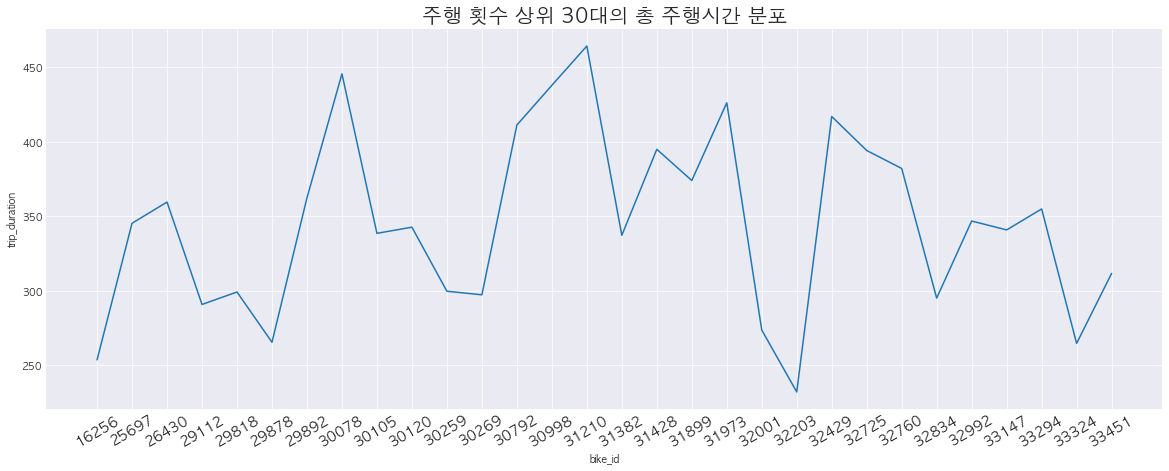

In [602]:
f, ax=plt.subplots(figsize=(20,7))
sns.lineplot('bike_id','trip_duration',data=data4)
plt.xticks(rotation=30, fontsize=14)
plt.title('주행 횟수 상위 30대의 총 주행시간 분포', fontsize=20)
plt.show()

### 주행 횟수 상위 30대의 시간대 분포

In [538]:
data5=cut_id2.groupby('start_hour').count()['bike_id'].reset_index()

In [539]:
data5=data5.sort_values(by='start_hour')

In [540]:
data5['start_hour']=data5['start_hour'].astype(str)

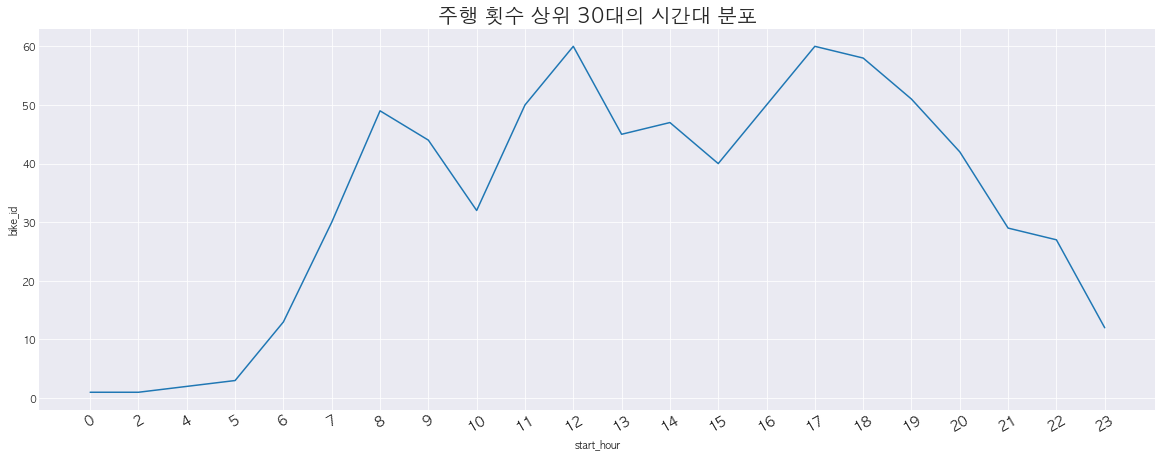

In [541]:
# 운행 거리 상위 30대의 start_time 분포 파악
f, ax=plt.subplots(figsize=(20,7))
sns.lineplot('start_hour','bike_id',data=data5, sort=False)
plt.xticks(rotation=30, fontsize=14)
plt.title('주행 횟수 상위 30대의 시간대 분포', fontsize=20)
plt.show()

### 분석
- 주행 횟수가 많을 수록 주행 시간이 길 것으로 예상했으나,
- 주행 횟수 상위 30대의 총 주행 시간 분포를 보면, 최대 7시간 30분(450분)을 기록하고 있다
- 그러나, 주행 시간 상위 30대의 총 주행 시간 분포를 보면, 최대 100시간(6000분...)까지 기록하고있다.
- 주행 횟수가 많은 (이용객들이 자주 이용하는) 자전거의 경우, 장거리 주행을 위해 이용하는 경우는 거의 없으며, 10~20분 정도의 단거리 이용을 위해 이용한다고 볼 수 있다
- 8,12,5-6시에 특히 많은 이용을 보이는 것으로 보아 출퇴근 이용객들이 자주 이용하는 것으로 보인다


### 2. Bike_id, Trip_duration, + 한 가지 변수 더 추가해서 3개 이상 변수 시각화 방식으로 시각화 해주세요.

### Bike_id, Trip_duration, Gaptime(day_since_register)
- 주행횟수 상위 30대의 이용객들이 이용 간격을 살펴본다

In [677]:
df_frq=cut_id2[['bike_id','day_since_register','trip_duration']]

In [678]:
df_frq=df_frq.sort_values(by=['bike_id','day_since_register'])

In [679]:
# 각 이용자들이 며칠에 한번씩 이용하는지 보기 위해
# day_since_register를 한칸씩 밀어서 이용한 날짜의 간격을 살펴보고싶다
df_frq['Gaptime']=df_frq['day_since_register'].shift(1)

In [680]:
df_frq.head()

,bike_id,day_since_register,trip_duration,Gaptime
587,16256,6,15.10,NaN
599,16256,10,5.90,6.0
586,16256,15,9.87,10.0
588,16256,16,13.00,15.0
607,16256,18,19.73,16.0


In [681]:
df_frq['Gaptime']=df_frq['day_since_register']-df_frq['Gaptime']

In [682]:
df_frq=df_frq.drop('day_since_register', axis=1)

In [683]:
df_frq.head()

,bike_id,trip_duration,Gaptime
587,16256,15.10,NaN
599,16256,5.90,4.0
586,16256,9.87,5.0
588,16256,13.00,1.0
607,16256,19.73,2.0


In [684]:
#using_frequency 가 0보다 작거나 nan 값은 0으로 바꿔준다
#밀어서 빼줬기 때문에
df_frq['Gaptime'].loc[(df_frq['Gaptime']<0)|(df_frq['Gaptime'].isnull())]=0


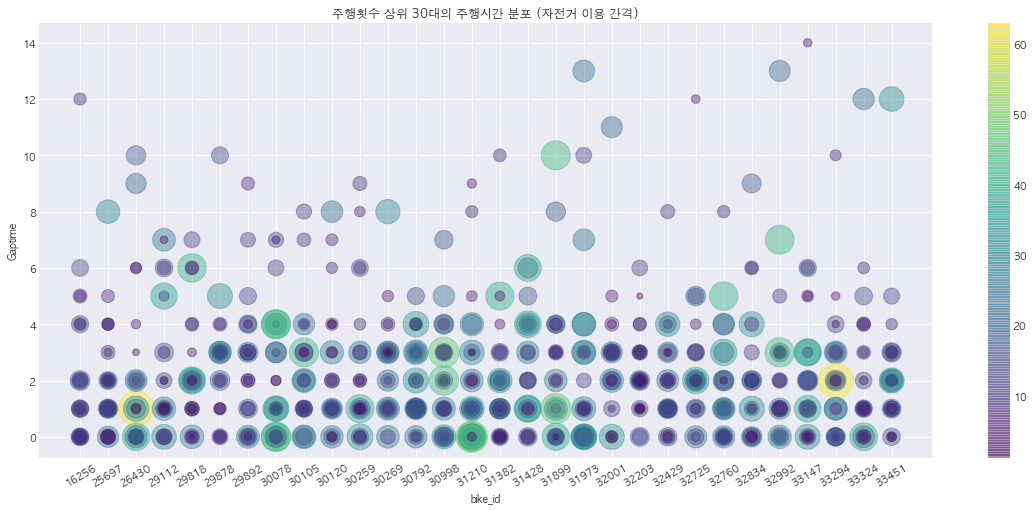

In [695]:
plt.figure(figsize=(20,8))
plt.scatter(df_frq['bike_id'],# x축bike_id
            df_frq['Gaptime'],# y축
            c=df_frq['trip_duration'], # 색상
            s=20*df_frq['trip_duration'], # 사이즈 
            # 10을 곱해본 이유는 그래프 사이즈에 맞게 원의 지름을 키워주기 위함
            alpha=0.4, # 투명도
            cmap='viridis') # 컬러바 종류

plt.colorbar()
plt.xlabel('bike_id')
plt.ylabel('Gaptime')
plt.xticks(rotation=30)
plt.title('주행횟수 상위 30대의 주행시간 분포 (자전거 이용 간격)')
plt.show()

### 분석
- 주행 횟수가 많은 자전거들은 상대적으로, 이용객들이 자주 이용하는 것을 알 수 있다
- 1일 간격으로 이용하는 자전거들도 다수 분포 (여러 원이 겹쳐져 있는 점들을 보면)
- 위의 자전거들이 놓여진 장소들은 자전거를 일상적으로 사용하는 이용객들이 많이 분포되어있다
